## Installations and Imports

In [1]:
!pip install torch_geometric

In [2]:
import random
import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.utils.convert import from_scipy_sparse_matrix
import scipy.sparse as sp
from torch_geometric.data import Data

from torch_geometric.datasets import CitationFull
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

import numpy as np

from torch_geometric import seed_everything
seed_everything(0)

## Loading the Datasets
Here we load in two different distributions of the CoraML dataset.

### From G2G Repo Dataset

We load this dataset according to the [g2g repo](https://github.com/abojchevski/graph2gauss/blob/master/g2g/utils.py#L461). The advantage of this distribution is that it contains mappings from the nodes back to the abstract's text of the original papers, which could allow us to perform qualitative evaluations down the line.

In [3]:
with np.load('./data/cora_ml.npz', allow_pickle = True) as loader:
    loader = dict(loader)
    g2g_adj = sp.csr_matrix((loader['adj_data'], loader['adj_indices'],
                       loader['adj_indptr']), shape=loader['adj_shape'])

    g2g_x = sp.csr_matrix((loader['attr_data'], loader['attr_indices'],
                       loader['attr_indptr']), shape=loader['attr_shape'])

    print("ABSTRACTS:\n", loader['attr_text'])

pt_g2g_x = torch.tensor(g2g_x.toarray(), dtype=torch.float)
pt_g2g_edge_index = from_scipy_sparse_matrix(g2g_adj)[0]
g2g_cora_ml = Data(x=pt_g2g_x, edge_index=pt_g2g_edge_index)
print("\nGRAPH DATA:")
g2g_cora_ml

ABSTRACTS:
 ["Intelligent information retrieval (IIR) requires inference. The number of inferences that can be drawn by even a simple reasoner is very large, and the inferential resources available to any practical computer system are limited. This problem is one long faced by AI researchers. In this paper, we present a method used by two recent machine learning programs for control of inference that is relevant to the design of IIR systems. The key feature of the approach is the use of explicit representations of desired knowledge, which we call knowledge goals. Our theory addresses the representation of knowledge goals, methods for generating and transforming these goals, and heuristics for selecting among potential inferences in order to feasibly satisfy such goals. In this view, IIR becomes a kind of planning: decisions about what to infer, how to infer and when to infer are based on representations of desired knowledge, as well as internal representations of the system's inferenti

Data(x=[2995, 2879], edge_index=[2, 8416])

### From PyG (Built-In)

This distribution of the same dataset comes built-in with PyG so it is easier to work with, but information about the original papers is lost since it only contains the embeddings and no mapping to the original vocabulary nor the papers.

In [4]:
pyg_cora_ml_full = CitationFull('data/CitationFull', 'Cora_ML', to_undirected=False)

In [5]:
pyg_cora_ml = pyg_cora_ml_full[0]
pyg_cora_ml

Data(x=[2995, 2879], edge_index=[2, 8416], y=[2995])

## Dataset Stats and Checking Agreement

### Dataset Info

In [6]:
print(f'Number of nodes: {pyg_cora_ml.num_nodes}')
print(f'Number of edges: {pyg_cora_ml.num_edges}')
print(f'Average node degree: {pyg_cora_ml.num_edges / pyg_cora_ml.num_nodes:.2f}')
print(f'Has isolated nodes: {pyg_cora_ml.has_isolated_nodes()}')
print(f'Has self-loops: {pyg_cora_ml.has_self_loops()}')
print(f'Is undirected: {pyg_cora_ml.is_undirected()}')

Number of nodes: 2995
Number of edges: 8416
Average node degree: 2.81
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [7]:
print(f'Number of nodes: {g2g_cora_ml.num_nodes}')
print(f'Number of edges: {g2g_cora_ml.num_edges}')
print(f'Average node degree: {g2g_cora_ml.num_edges / pyg_cora_ml.num_nodes:.2f}')
print(f'Has isolated nodes: {g2g_cora_ml.has_isolated_nodes()}')
print(f'Has self-loops: {g2g_cora_ml.has_self_loops()}')
print(f'Is undirected: {g2g_cora_ml.is_undirected()}')

Number of nodes: 2995
Number of edges: 8416
Average node degree: 2.81
Has isolated nodes: False
Has self-loops: False
Is undirected: False


### Checking Agreement of Adjacency Matrix

Checking if the edges match.

In [8]:
torch.allclose(pyg_cora_ml.edge_index, g2g_cora_ml.edge_index)

True

### Checking Agreement of Embeddings

Here we check using a few different methods of converting between sparse and dense matrices just to be safe.

In [9]:
torch.allclose(pyg_cora_ml.x, g2g_cora_ml.x)

False

In [10]:
pyg_cora_ml.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [11]:
g2g_x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
np.allclose(g2g_x.toarray(), pyg_cora_ml.x.cpu().detach().numpy())

False

In [13]:
pt_tensor = torch.sparse_coo_tensor(g2g_x.nonzero(), g2g_x.data, g2g_x.shape)
pt_tensor.to_dense()

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2808723335.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  pt_tensor = torch.sparse_coo_tensor(g2g_x.nonzero(), g2g_x.data, g2g_x.shape)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [14]:
np.allclose(pt_tensor.to_dense().cpu().detach().numpy(), pyg_cora_ml.x.cpu().detach().numpy())

False

In [15]:
g2g_x_coo = g2g_x.tocoo()

pt_idx = np.vstack((g2g_x_coo.row, g2g_x_coo.col))
pt_vals = g2g_x_coo.data

pt_i = torch.LongTensor(pt_idx)
pt_v = torch.FloatTensor(pt_vals)
shape = g2g_x_coo.shape

pt_via_coo = torch.sparse.FloatTensor(pt_i, pt_v, torch.Size(shape)).to_dense()
pt_via_coo

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
np.allclose(pt_via_coo.cpu().detach().numpy(), pyg_cora_ml.x.cpu().detach().numpy())

False

The embeddings don't match!

## Visualization

In [17]:
def viz_graph_spring(graph, n_sample=None):
  nx_graph = to_networkx(graph, node_attrs=["x"])

  if n_sample:
    samples = random.sample(nx_graph.nodes, n_sample)
    nx_graph = nx_graph.subgraph(samples)

  plt.figure(figsize=(9, 7))
  nx.draw_spring(nx_graph, node_size=30)
  plt.show()

def viz_graph_circular(graph, n_sample=None):
  nx_graph = to_networkx(graph, node_attrs=["x"])

  if n_sample:
    samples = random.sample(nx_graph.nodes, n_sample)
    nx_graph = nx_graph.subgraph(samples)

  plt.figure(figsize=(9, 7))
  nx.draw_circular(nx_graph, node_size=30)
  plt.show()

def viz_graph_spectral(graph, n_sample=None):
  nx_graph = to_networkx(graph, node_attrs=["x"])

  if n_sample:
    samples = random.sample(nx_graph.nodes, n_sample)
    nx_graph = nx_graph.subgraph(samples)

  plt.figure(figsize=(9, 7))
  nx.draw_spectral(nx_graph, node_size=30)
  plt.show()

def viz_graph_kamada_kawai(graph, n_sample=None):
  nx_graph = to_networkx(graph, node_attrs=["x"])

  if n_sample:
    samples = random.sample(nx_graph.nodes, n_sample)
    nx_graph = nx_graph.subgraph(samples)

  plt.figure(figsize=(9, 7))
  nx.draw_kamada_kawai(nx_graph, node_size=30)
  plt.show()

def viz_graph_random(graph, n_sample=None):
  nx_graph = to_networkx(graph, node_attrs=["x"])

  if n_sample:
    samples = random.sample(nx_graph.nodes, n_sample)
    nx_graph = nx_graph.subgraph(samples)

  plt.figure(figsize=(9, 7))
  nx.draw_random(nx_graph, node_size=30)
  plt.show()

def viz_graph_shell(graph, n_sample=None):
  nx_graph = to_networkx(graph, node_attrs=["x"])

  if n_sample:
    samples = random.sample(nx_graph.nodes, n_sample)
    nx_graph = nx_graph.subgraph(samples)

  plt.figure(figsize=(9, 7))
  nx.draw_shell(nx_graph, node_size=30)
  plt.show()

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2049223126.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samples = random.sample(nx_graph.nodes, n_sample)


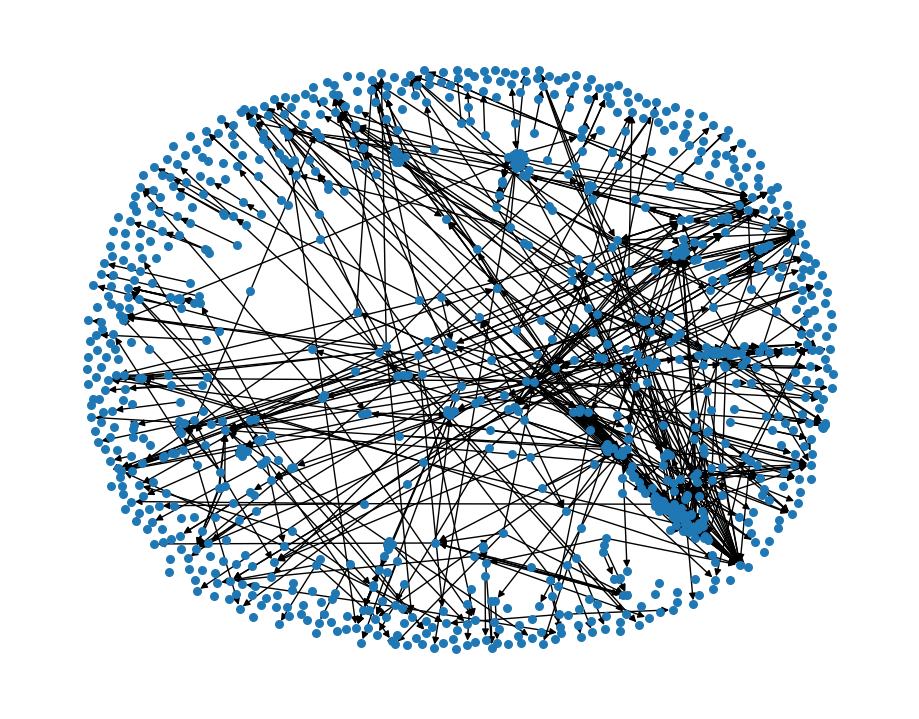

In [18]:
viz_graph_spring(pyg_cora_ml, 1000)

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2049223126.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samples = random.sample(nx_graph.nodes, n_sample)


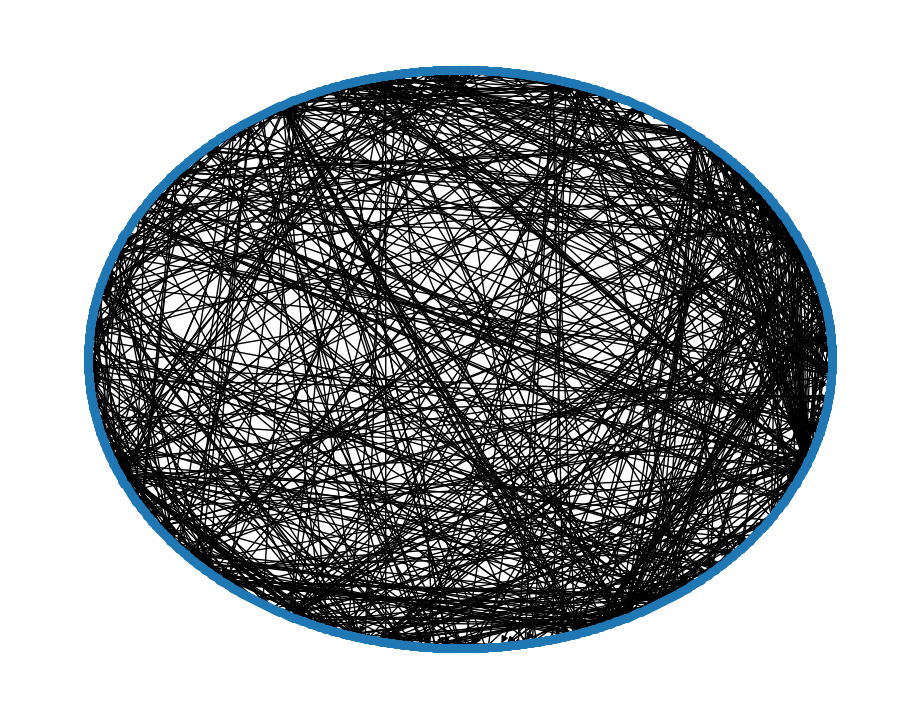

In [19]:
viz_graph_circular(pyg_cora_ml, 1000)

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2049223126.py:49: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samples = random.sample(nx_graph.nodes, n_sample)


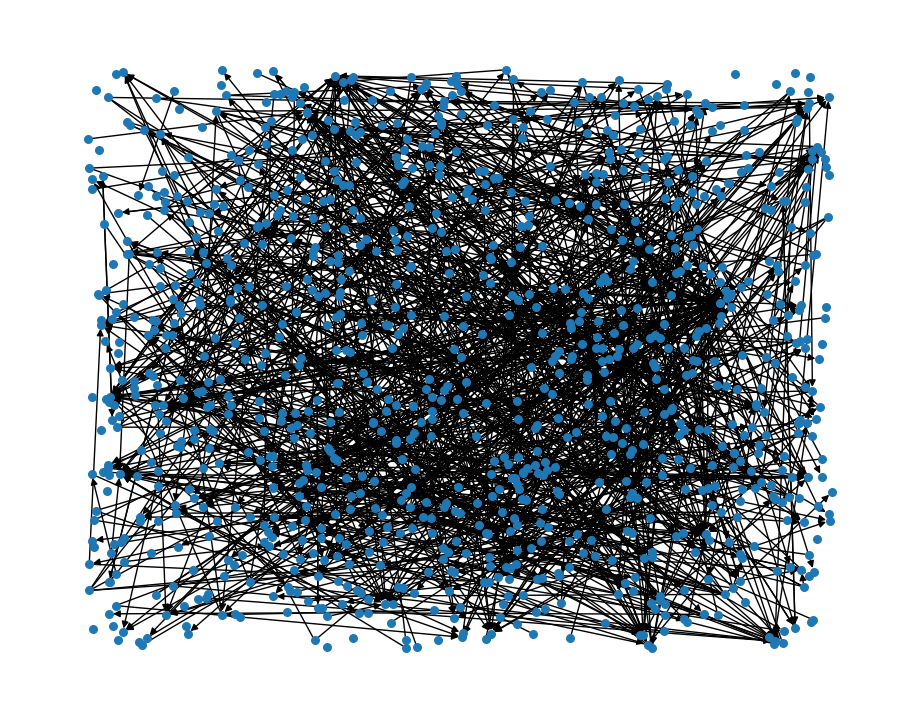

In [20]:
viz_graph_random(pyg_cora_ml, 1000)

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2049223126.py:27: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samples = random.sample(nx_graph.nodes, n_sample)


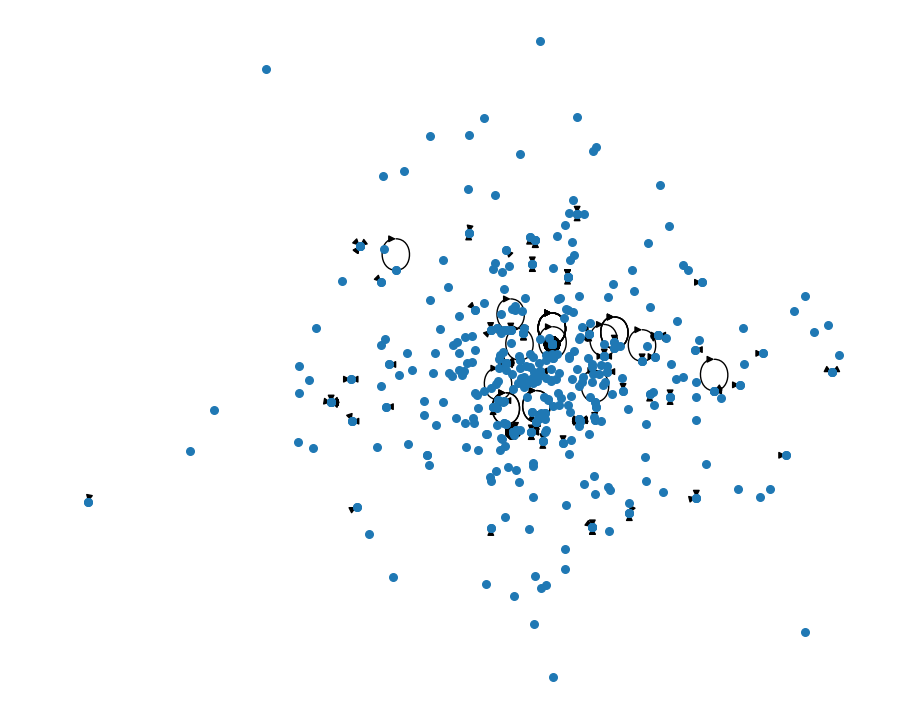

In [21]:
viz_graph_spectral(pyg_cora_ml, 1000)

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2049223126.py:60: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samples = random.sample(nx_graph.nodes, n_sample)


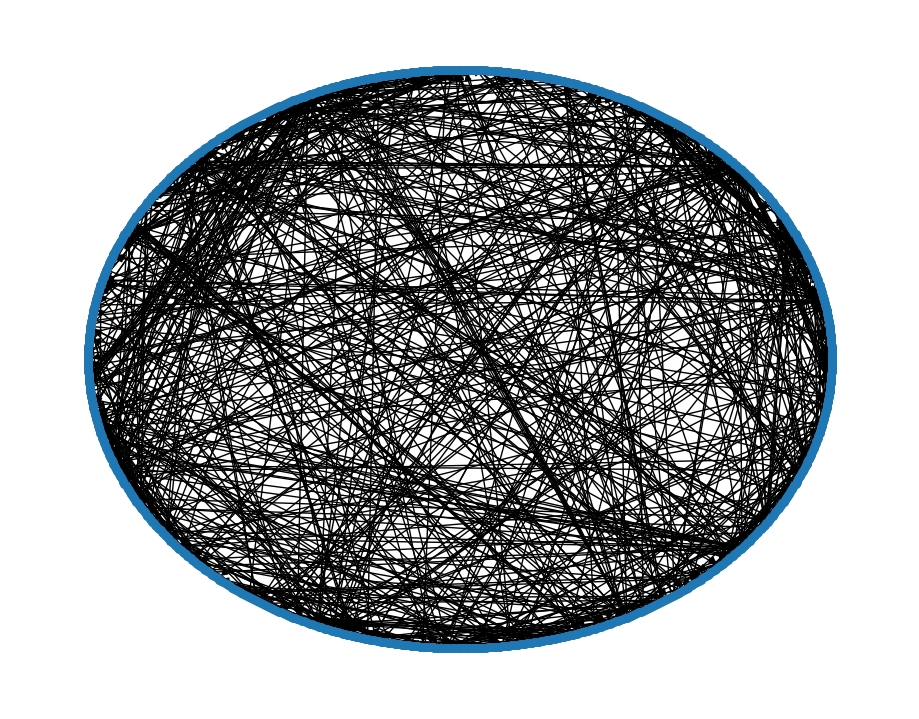

In [22]:
viz_graph_shell(pyg_cora_ml, 1000)

C:\Users\libow\AppData\Local\Temp\ipykernel_32048\2049223126.py:38: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samples = random.sample(nx_graph.nodes, n_sample)


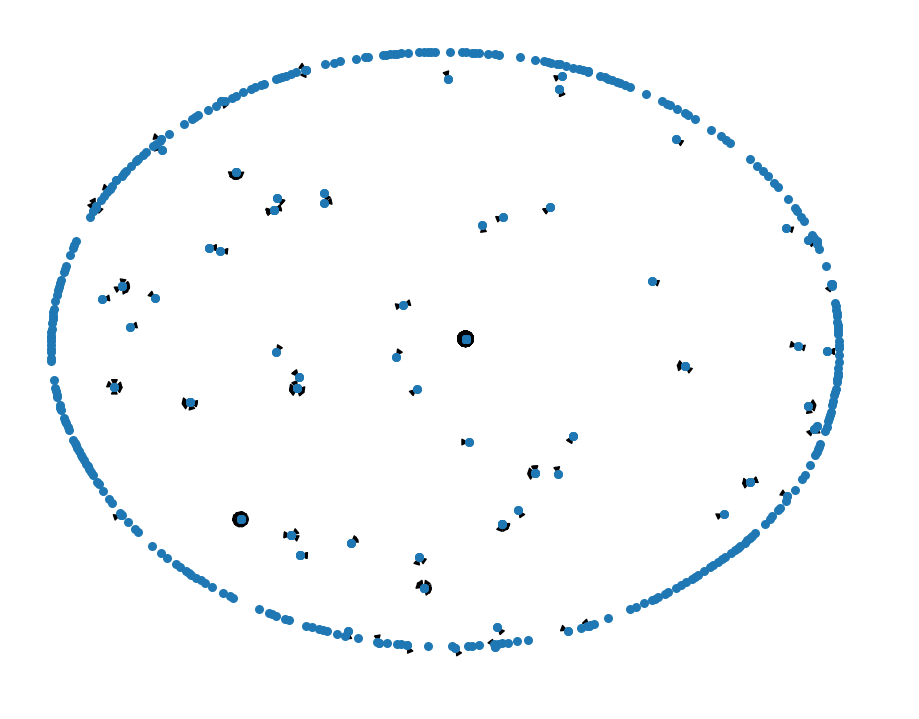

In [23]:
viz_graph_kamada_kawai(pyg_cora_ml, 1000)

## Initial Model Testing

Basic model adapted from PyG's [link prediction](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py) example code.

### Model Definition and Setup

In [24]:
class Net(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)

  def encode(self, x, edge_index):
    a1 = self.conv1(x, edge_index).relu()
    a2 = self.conv2(a1, edge_index)
    return a2

  def decode(self, z, edge_label_index):
    return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

  def decode_all(self, z):
    s = z @ z.T
    return (s > 0).nonzero(as_tuple=False).T


In [25]:
def train(model, train_data, val_data, optimizer, criterion, n_epochs=100):

  train_error = np.zeros(n_epochs)
  val_error = np.zeros(n_epochs)

  for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      train_auc = roc_auc_score(edge_label.cpu().numpy(), out.cpu().numpy())
      train_error[epoch-1] = 1 - train_auc

    val_auc = evaluate(model, val_data)

    val_error[epoch-1] = 1 - val_auc

    if epoch % 10 == 0:
      print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

  return model, train_error, val_error


In [26]:
@torch.no_grad()
def evaluate(model, data):
  model.eval()
  z = model.encode(data.x, data.edge_index)
  out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

  return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


### Test on PyG Dataset

In [27]:
graph = pyg_cora_ml

split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

In [28]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[2995, 2879], edge_index=[2, 7316], y=[2995], edge_label=[3658], edge_label_index=[2, 3658])
Data(x=[2995, 2879], edge_index=[2, 7316], y=[2995], edge_label=[430], edge_label_index=[2, 430])
Data(x=[2995, 2879], edge_index=[2, 7746], y=[2995], edge_label=[860], edge_label_index=[2, 860])


In [29]:
EPOCHS = 30

model = Net(pyg_cora_ml.num_features, 128, 64).to('cpu')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
model, train_errs, val_errs  = train(model, train_data, val_data, optimizer, criterion, n_epochs=EPOCHS)

test_auc = evaluate(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.441, Val AUC: 0.917
Epoch: 020, Train Loss: 0.429, Val AUC: 0.940
Epoch: 030, Train Loss: 0.403, Val AUC: 0.933
Test: 0.928


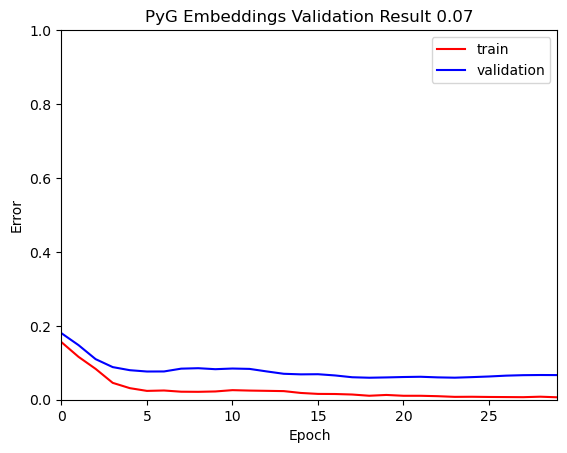

In [30]:
fig, ax = plt.subplots()
ax.plot(train_errs,'r-',label='train')
ax.plot(val_errs,'b-',label='validation')
ax.set_ylim(0,1); ax.set_xlim(0,29)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('PyG Embeddings Validation Result %3.2f'%(val_errs[-1]))
ax.legend()
plt.show()

### Test on G2G Dataset

In [31]:
graph = g2g_cora_ml

split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

In [32]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[2995, 2879], edge_index=[2, 7316], edge_label=[3658], edge_label_index=[2, 3658])
Data(x=[2995, 2879], edge_index=[2, 7316], edge_label=[430], edge_label_index=[2, 430])
Data(x=[2995, 2879], edge_index=[2, 7746], edge_label=[860], edge_label_index=[2, 860])


In [33]:
EPOCHS = 100

model = Net(g2g_cora_ml.num_features, 128, 64).to('cpu')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
model, train_errs, val_errs  = train(model, train_data, val_data, optimizer, criterion, n_epochs=EPOCHS)

test_auc = evaluate(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.654, Val AUC: 0.763
Epoch: 020, Train Loss: 0.606, Val AUC: 0.789
Epoch: 030, Train Loss: 0.545, Val AUC: 0.847
Epoch: 040, Train Loss: 0.494, Val AUC: 0.854
Epoch: 050, Train Loss: 0.462, Val AUC: 0.883
Epoch: 060, Train Loss: 0.452, Val AUC: 0.892
Epoch: 070, Train Loss: 0.438, Val AUC: 0.909
Epoch: 080, Train Loss: 0.430, Val AUC: 0.920
Epoch: 090, Train Loss: 0.425, Val AUC: 0.922
Epoch: 100, Train Loss: 0.424, Val AUC: 0.924
Test: 0.944


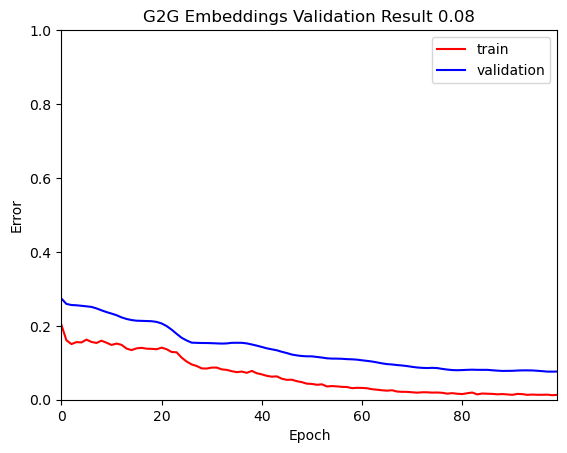

In [34]:
fig, ax = plt.subplots()
ax.plot(train_errs,'r-',label='train')
ax.plot(val_errs,'b-',label='validation')
ax.set_ylim(0,1); ax.set_xlim(0,EPOCHS-1)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('G2G Embeddings Validation Result %3.2f'%(val_errs[-1]))
ax.legend()
plt.show()